# Best-Practices Handbook - Joining time series with different frequencies

### Definition

From a generalised perspective, we can say that a high frequency time series has observations recorded as:
  $$
  X_{t_i} = \{x_{t1}, x_{t2}, x_{t3}, \ldots, x_n\}, \text{ where } t_i \text{ represents each interval (e.g., every minute).}
  $$

While a low frequency time serise has observations:
  $$
  Y_{t_j} = \{y_{t1}, y_{t2}, y_{t3}, \ldots, y_m\}, \text{ where } t_j \text{ represents each less frequent interval (e.g., weekly).}
  $$

### Description

When working with time series data (e.g. asset prices), it is quite common for the data to have different observation frequencies. For example, when looking at trade data, a liquid asset might trade every few seconds while an illiquid asset may only trade once a day, perhaps only once a week. Here, the liquid asset has price observations that do not have any matching counterparts in the illiquid series. 

When joining time series with different frequencies, our aim is to get the two series to a common frequency before we continue our analysis and modeling (Seong, 2020). In order to achieve a common frequency, we have two main options:
1. Only use available data as supplied or measured. This approach often means that not all information from the time series for which we have more oberservations is used. Meaning, the method discards existing data points that carry useful information. 
2. Create proxy data values for the time series that has fewer data points. There are many methods for approaching missing data points, the best method to choose often depends on (a) how much data is missing, and (b) what we are looking to model. 

For the more complex 2nd option, some common methods include: 
- Imputation: Replace missing values with e.g. mean, median or mode.
- (Linear) Interpolation: Estimate missing values between adjacent known values.
- Forward/backward Fill: Fill the missing value with the previous or next known value.

### Demonstration & Diagram

In the below, we will look at daily S&P 500 Index adjusted closing prices along with monthly US Unemployment Rates. Here, the S&P 500 data has a higher frequency (daily) compared to the Unemployment Rate (monthly). We will illustrate the challenges in joining the two time series with the aim of finding a way to get them to a common frequency.

In [1]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Helper Graph Function
def graph_dual_axis(sp500_data, unemployment_data, title, sp500_label, unemployment_label):
    fig, ax1 = plt.subplots()

    ax1.plot(sp500_data.index, sp500_data["Adj Close"], color="blue", label=sp500_label)

    ax1.set_xlabel("Date")
    ax1.set_ylabel("Price (USD)", color="blue")

    ax2 = ax1.twinx()
    ax2.plot(
        unemployment_data.index,
        unemployment_data["UNRATE"],
        color="orange",
        label=unemployment_label,
    )
    ax2.set_ylabel("Unemployment Rate (%)", color="orange")

    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc="upper left")

    plt.title(title)
    plt.show()

In [3]:
df_sp500 = yf.download("^GSPC", start="2019-04-01", end="2024-04-01")
df_sp500.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-04-01,2848.629883,2869.399902,2848.629883,2867.189941,2867.189941,3560090000
2019-04-02,2868.239990,2872.899902,2858.750000,2867.239990,2867.239990,3267210000
2019-04-03,2876.090088,2885.250000,2865.169922,2873.399902,2873.399902,3570000000
2019-04-04,2873.989990,2881.280029,2867.139893,2879.389893,2879.389893,3038740000
2019-04-05,2884.159912,2893.239990,2882.989990,2892.739990,2892.739990,3155970000


In [4]:
df_unrate = pd.read_csv('UNRATE.csv', parse_dates=['DATE'], index_col='DATE')
df_unrate = df_unrate[df_unrate.index > '2019-03-01']
df_unrate.head()

,UNRATE
DATE,
2019-04-01,3.7
2019-05-01,3.6
2019-06-01,3.6
2019-07-01,3.7
2019-08-01,3.6


In [5]:
print('S&P Index Time Frame:', df_sp500.index.min().date(), '-', df_sp500.index.max().date())
print(
    "Unemployment Time Frame:",
    df_unrate.index.min().date(),
    "-",
    df_unrate.index.max().date(),
)

S&P Index Time Frame: 2019-04-01 - 2024-03-28
Unemployment Time Frame: 2019-04-01 - 2024-04-01


In [6]:
print('S&P 500 Observations:', len(df_sp500), ', Unemployment Rate Observations:',
      len(df_unrate))

S&P 500 Observations: 1258 , Unemployment Rate Observations: 61


Although the two time series cover the same time frame, the number of observations are drastically different. We see that the S&P 500 Index has about 20 times as many data points as the unemployment rate.

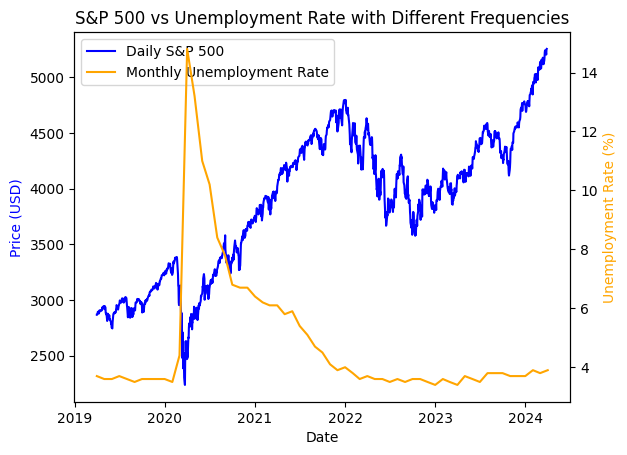

In [7]:
graph_dual_axis(
    sp500_data=df_sp500,
    unemployment_data=df_unrate,
    title="S&P 500 vs Unemployment Rate with Different Frequencies",
    sp500_label="Daily S&P 500",
    unemployment_label="Monthly Unemployment Rate"
)

Inspecting the graph above, we also notice that the S&P 500 graph is much smoother and has more details than the unemployment rate which is choppier and much less granular.

Let's see what would happen if we joined these two time series into one DataFrame.

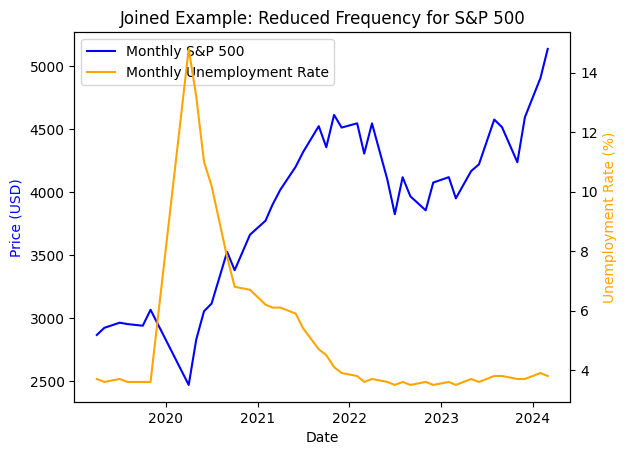

In [8]:
df_join1 = df_sp500.join(df_unrate, how='inner')[['Adj Close', 'UNRATE']].round(2)

graph_dual_axis(
    sp500_data=df_join1,
    unemployment_data=df_join1,
    title="Joined Example: Reduced Frequency for S&P 500",
    sp500_label="Monthly S&P 500",
    unemployment_label="Monthly Unemployment Rate"
)

The selected inner join only keeps data for timestamps where both time series have observations. As a result, we have dropped data from the S&P 500 data set and reduced the frequency to match the monthly unemployment rate.

##### Exagerated Frequency Example

For the sake of the example, let's assume we only use the unemployment rate at annul intervals, each year on January 1st.

In [9]:
year_start = pd.date_range(
    start=df_unrate.index.min(), end=df_unrate.index.max(), freq="YS"
)

df_unrate_extreme = df_unrate[df_unrate.index.isin(year_start)]
df_unrate_extreme

,UNRATE
DATE,
2020-01-01,3.6
2021-01-01,6.4
2022-01-01,4.0
2023-01-01,3.4
2024-01-01,3.7


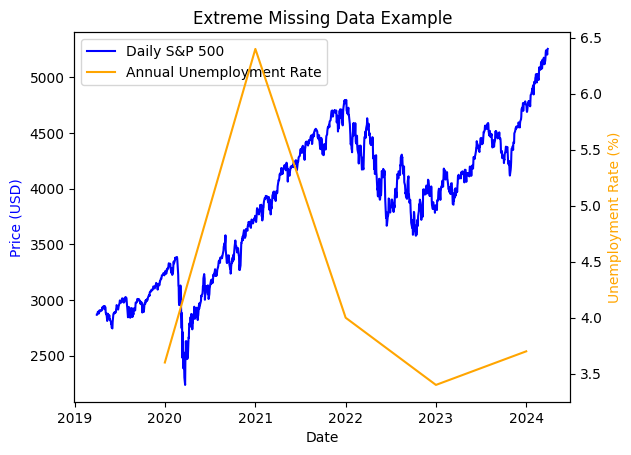

In [12]:
graph_dual_axis(
    sp500_data=df_sp500,
    unemployment_data=df_unrate_extreme,
    title="Extreme Missing Data Example",
    sp500_label="Daily S&P 500",
    unemployment_label="Annual Unemployment Rate",
)

Of course this a syntheticly created data example where we manually removed some existing data. However, we sometimes come across instances like this in the real world of data modeling where we have extreme discreptancies between data frequencies. If we joined these series in the same way as we did the daily and monthly values, we'd be left with a total of 10 data points which would prove rather useless for modeling. 

In the later _Directions_ section, we will discuss ways to keep the S&P 500 data and add to the unemployment rate data set to create a higher frequency that matches the daily S&P 500. 

### Diagnosis

Throughout the above _Demonstration & Diagram_ section, we identified a few ways to assess whether our time series have the same frequency. To summarise, we can:
1. Consider the number of observations in each time series. If they vary for the same time frame, we are likely dealing with a frequency issue. When joining two series where one has more observations than the other, we will either drop valuable information from the higher frequency series, or end up with nan values for the lower frequency data set.
2. Plot the time series helps us analyse the smoothness of the graph. A time series with more data points, i.e., higher frequency, tends to be smoother than a time series with less data points, i.e., lower frequency.
3. Note the pattern of the datetime index. The datetime index or time stamp of the time series at hand can help us understand whether two series have the same frequency. This can be used as a first glance visual inspection but is often not practical for larger data sets. 

### Damage

The data examples described above help us understand some key issues we experience when joining time series with different frequencies. The first problem arises when attempting to bring the time series to a common frequency. This involves either discarding useful data points or involves generation of proxy data values. If a proxy generation approach is chosen, the next issue lies in finding a suitable method. 

### Directions

There are various ways we can handle inconsistent frequencies. Of course it depends on the situation but typically, the preferred way is to generate proxy data points to fill the gaps of the lower frequency time series. Below, we discuss two possible examples are shown that are frequently used to generate such proxy data points.

##### Forward Fill

Forward filling replicates the last known observation and uses it for the following period(s), either for a limited number of periods as specified or until the next observation is available. Carrying forward the last available data point does not make any assumptions about the direction the series develops into but does assume stationarity.

In [19]:
df_join2 = df_sp500[['Adj Close']].merge(df_unrate, how='left', left_on=df_sp500.index, right_on=df_unrate.index).set_index(df_sp500.index).drop(columns='key_0')
df_join2.head()

,Adj Close,UNRATE
Date,,
2019-04-01,2867.189941,3.7
2019-04-02,2867.239990,NaN
2019-04-03,2873.399902,NaN
2019-04-04,2879.389893,NaN
2019-04-05,2892.739990,NaN


In [24]:
df_join2['UNRATE'].ffill(inplace=True)
df_join2.head()

,Adj Close,UNRATE
Date,,
2019-04-01,2867.189941,3.7
2019-04-02,2867.239990,3.7
2019-04-03,2873.399902,3.7
2019-04-04,2879.389893,3.7
2019-04-05,2892.739990,3.7


''

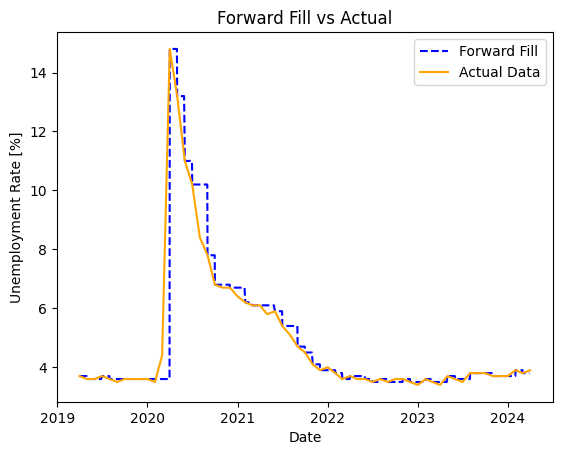

In [32]:
fig, ax = plt.subplots()

ax.plot(
    df_join2.index,
    df_join2["UNRATE"],
    color="blue",
    linestyle='--', 
    label="Forward Fill"
)

ax.plot(df_unrate.index, df_unrate["UNRATE"], color="orange", label="Actual Data")

ax.set_xlabel('Date')
ax.set_ylabel('Unemployment Rate [%]')
ax.set_title('Forward Fill vs Actual')
ax.legend()
;

When graphed, we observe a step function as a result from the forward fil method. This also leads us to one of the issues with forward (or backward) fill: Replicating values can change the distribution. In our example, we forward fill from the 1st of the month to the last day of the month. This means we replicate some data points 31 times while others only 28 times. In other scenarios, the differences might be even larger which could lead to a more siginifant impact on the distribution and its moments.

##### Larger Data Gaps Example

Let's assume we have a larger period of missing data in our time series, which is a realistic problem we might face when analysing data and building a model. For the purpose of the example, we will take out observations between Apr-2020 and Jan-2023 from the unemployment rate data set.

''

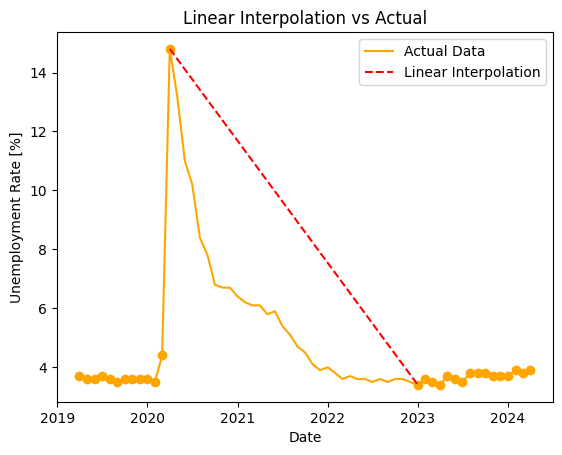

In [ ]:
df_unrate_missing = df_unrate[
    (df_unrate.index < "2020-04-02") | (df_unrate.index > "2022-12-31")
]
df_unrate_missing

fig, ax = plt.subplots()

ax.scatter(
    df_unrate_missing.index,
    df_unrate_missing["UNRATE"],
    color="orange",
)

ax.plot(df_unrate.index, df_unrate["UNRATE"], color="orange", label="Actual Data")
ax.plot(
    df_unrate_missing[(df_unrate_missing.index > "2020-03-31") & (df_unrate_missing.index
    < "2023-01-02")], color="red", linestyle='--', label='Linear Interpolation'
)

ax.set_xlabel('Date')
ax.set_ylabel('Unemployment Rate [%]')
ax.set_title('Linear Interpolation vs Actual')
ax.legend()
;

We can see with the gap in the data, we would be unable to track the recovery of the unemployment rate from the Covid shock. To compensate for the missing data, the above graph shows a linearly interpolated recovery (red). Looking at the actual data (orange), we know that the majority of the recovery actually happened before the end of 2020 and by the beginnning of 2022, the unemployment rate was back down to pre-Covid levels. Our linearly interpolated graph does not reflect this which shows one potential issue we face when using linear interpolation to fill missing data values. 

Linking this back to our goal of joining two time series with different frequencies; we are missing a lot of information about the recovery of the unemployment rate during an interesting period. When looking to understand the relationship between two time series that have different data frequency or missing values, we need to carefully select a method for joining the two data sets that is realistic in order to extract as much information from the available observations as possible.

### Further Discussion

Many commonly used methods for generating proxy values assume that missing values are not extreme or, rather, not more extreme than any values we have observed. For example, using imputation means that gaps are filled with the sample's mode, mean, or median, all of which are typically close to the center of the distribution. Especially if used for a significant amount of data points, this can introduce bias to any model that is built with reliance on the inputs. 

DISCUSS OTHER METHODS

### References
1. Seong, Byeongchan. "Smoothing and forecasting mixed-frequency time series with vector exponential smoothing models." Jul. 2020.
2. Casals, José et al. "Modeling and Forecasting Time Series Sampled at Different Frequencies.", Journal of Forecasting 28(4):316 - 342, Jul. 2009. 
3. Hyung, Namwon. "Linking series generated at different frequencies and its applications.", Research Notes, No. 99-1, Deutsche Bank Research, Dec. 1998.
4. Unemployment Data Source: fred.stlouisfed.org/series/UNRATE